In [278]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [553]:
img = cv2.imread(os.path.join('demo', 'kover1.jpg'), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA, img)
# img = cv2.resize(img, (720, 480))
img = ndimage.rotate(img , 0, reshape=True)

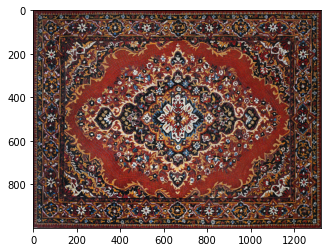

In [554]:
plt.imshow(img)

In [436]:
alpha = 50


In [747]:
def warp_perspective(img, alpha, dz=None, dy=0, dx=0):
    alpha = (alpha - 90.)*np.pi/180

    if dz is None:
        dz = max(img.shape)*1.4
    f = max(img.shape)
    w = img.shape[0]
    h = img.shape[1]

    A1 = np.array([[1, 0, -w/2],
                  [0, 1,-h/2],
                  [0, 0, 0],
                  [0, 0, 1]])

    RX = np.array([[1, 0, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha), 0],
                   [0, np.sin(alpha),  np.cos(alpha), 0],
                   [0, 0, 0, 1]])
    RY = np.array([[np.cos(0), 0, -np.sin(0), 0],
                   [0, 1, 0, 0],
                   [np.sin(0), 0,  np.cos(0), 0],
                   [0, 0, 0, 1]])
    RZ = np.array([[np.cos(0), -np.sin(0), 0, 0],
                   [np.sin(0),  np.cos(0), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]]);
    R = RX.dot(RY).dot(RZ)

    T = np.array([[1, 0, 0, dx],
                  [0, 1, 0, dy],
                  [0, 0, 1, dz],
                  [0, 0, 0, 1]])
    A2 = np.array([[f, 0, w/2, 0],
                   [0, f, h/2, 0],
                   [0, 0,   1, 0]])
    trans = R.dot(A1)
    trans = T.dot(trans)
    trans = A2.dot(trans)
    warp = cv2.warpPerspective(img, trans, (img.shape[1], img.shape[0]), cv2.INTER_LANCZOS4)
    return warp, trans

In [170]:
def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold

    Crops blank image to 1x1.

    Returns cropped image.

    """
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

In [221]:
from models.models import create_model
from data.data_loader import inference_transform
from argparse import Namespace
import torch

opt = Namespace(**{'mode': 'ResNet', 'dataset': 'interiornet', 'gpu_ids':0, 'isTrain': True,
                   'checkpoints_dir': './checkpoints/', 'name':'test_local'})
model = create_model(opt, _isTrain=False)
model.switch_to_train()

./checkpoints/test_local/_best_interiornet_ry_exp_upright_9_sphere_ls_mode_ResnetModel3HeadsSplitNormalizationTightCoupled_lr_0.0004_w_svd_2.0_w_grad_0.25_backprop_eig_1_net_G.pth
---------- Networks initialized -------------
-----------------------------------------------
model [UprightNet] was created


In [842]:
room_img = cv2.imread(os.path.join('demo', 'input_imgs', '12_1.jpg'))
width, height = room_img.shape[1], room_img.shape[0] 

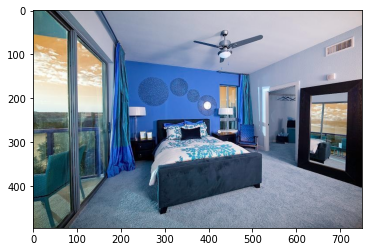

In [843]:
plt.imshow(room_img)

In [844]:
transformed_img = inference_transform({'img': room_img})
est_up_n, pred_roll, pred_pitch = model.infer_model(transformed_img.unsqueeze(0), 1)

In [845]:
print(pred_pitch)

-0.032702645803736455


In [846]:
if pred_pitch < -0.4:
    angle = max((70 - 65 * (1 + pred_pitch)), 20)
else:
    angle = max((80 - 65 * (1 + pred_pitch)), 20)
# angle = 10
print(angle, pred_pitch)

20 -0.032702645803736455


(221, 1141, 4)


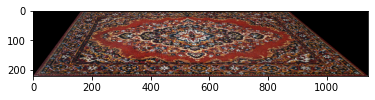

In [803]:
warped, _ = warp_perspective(img, angle)

warped = autocrop(warped)
plt.imshow(warped[...,[0,1,2]])
print(warped.shape)
warped = cv2.resize(warped, (int(warped.shape[1]/5), int(warped.shape[0]/5)))
x_offset= 350
y_offset = 450
alpha_mask = np.zeros([*warped[...,-1].shape, 3], dtype=np.uint8)
alpha_mask[...,0] = warped[...,-1]/255
alpha_mask[...,1] = warped[...,-1]/255
alpha_mask[...,2] = warped[...,-1]/255
result = room_img.copy()
warped_background = result[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]].copy()
warped_background = np.multiply(warped_background, alpha_mask)
result[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]] += -warped_background + warped[...,[2,1,0]]


True

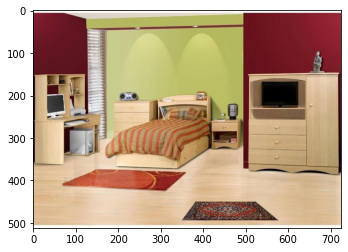

In [804]:
plt.imshow(result[...,::-1])
cv2.imwrite(os.path.join('demo', 'result', '12_1_carpet.jpg'), result)

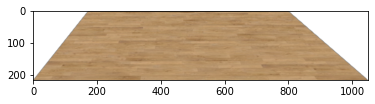

In [847]:
texture = cv2.imread(os.path.join('demo', 'floor_cover2.jpg'), cv2.IMREAD_UNCHANGED)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGBA, texture)
texture = ndimage.rotate(texture , 0, reshape=True)
warped_texture, _ = warp_perspective(texture, angle)
warped_texture = autocrop(warped_texture)
scale = width / warped_texture.shape[1] 
warped_texture = cv2.resize(warped_texture, (int(warped_texture.shape[1]*scale*1.4),
                                             int(warped_texture.shape[0]*scale*1.4)))
plt.imshow(warped_texture)
center_offset = int((warped_texture.shape[1] - width)/2)
top_offset = min(height, warped_texture.shape[0])
warped_texture = warped_texture[-top_offset:,center_offset:center_offset+width,]

In [848]:
mask = cv2.imread(os.path.join('demo', 'input_imgs', '12_mask.png'), cv2.IMREAD_UNCHANGED)[...,::-1] == 3
alpha_mask = np.zeros([*mask.shape, 3], dtype=np.uint8)
alpha_mask[...,0] = mask
alpha_mask[...,1] = mask
alpha_mask[...,2] = mask
result = room_img.copy() - room_img * alpha_mask
_ = np.zeros([*mask.shape, 3], dtype=np.uint8)
_[-warped_texture.shape[0]:, result.shape[1]-warped_texture.shape[1]:] = cv2.cvtColor(warped_texture, cv2.COLOR_RGBA2BGR)
warped_texture = _
result[-warped_texture.shape[0]:, result.shape[1]-warped_texture.shape[1]:] += \
                                    warped_texture * alpha_mask
cv2.imwrite(os.path.join('demo', 'result', '12_1_texture.jpg'), result)

True

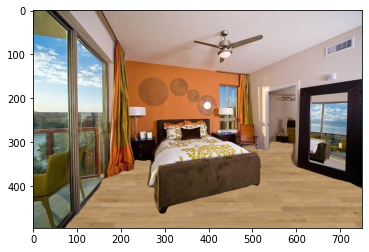

In [849]:
plt.imshow(result[...,::-1])


In [783]:
print(alpha_mask)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]


In [760]:
print(warped_texture)

[[[133 162 199]
  [133 162 199]
  [132 161 198]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[133 162 199]
  [133 162 199]
  [133 162 199]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[131 160 197]
  [132 161 198]
  [133 161 198]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[123 152 189]
  [122 151 188]
  [122 151 188]
  ...
  [116 153 187]
  [117 154 188]
  [116 153 187]]

 [[124 153 190]
  [123 152 189]
  [122 151 188]
  ...
  [119 156 190]
  [119 156 190]
  [118 155 189]]

 [[124 154 191]
  [123 152 189]
  [122 151 188]
  ...
  [120 157 191]
  [120 157 191]
  [119 156 190]]]
